In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy

# Adding library directory to python search path
import sys
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

# Create directory for generated .tex and .pdf
if not os.path.exists('gen'):
    os.mkdir('gen')

In [3]:
class consts:
    pi = 3.141592
    c  = 3 * 10**8 # m/s
    mu_0 = 4 * pi * 10**-7 # N * A^-2

class material:
    N0 = 0
    S = 0    # cm^2
    NU = 0
    _2pR = 0 # cm

    K_x = 0 # mV
    K_y = 0 # mV
    I   = 0 # mA

    H_c = 0 # div
    B_r = 0 # div
    X_s = 0 # div
    Y_s = 0 # div

    ref_mu_0 = 0
    ref_mu_max = 0

    def __init__(self, N0, S, NU, _2pR, K_x, K_y, I, H_c, B_r, X_s, Y_s, ref_mu_0, ref_mu_max):
        self.N0 = N0
        self.S = S
        self.NU = NU
        self._2pR = _2pR

        self.K_x = K_x # mV
        self.K_y = K_y # mV
        self.I   = I   # mA

        self.H_c = H_c # div
        self.B_r = B_r # div
        self.X_s = X_s # div
        self.Y_s = Y_s # div

        self.ref_mu_0 = ref_mu_0
        self.ref_mu_max = ref_mu_max

    def H(self, x): # A / m
        return (x * self.K_x / 1000 / setup.R_0) * self.N0 / (self._2pR / 100)

    def B(self, y): # T
        return (y * self.K_y / 1000) * setup.tau / ((self.S / 100**2) * self.NU)

class setup:
    dummy = 0

    div_err = 0.15 # div
    R_0 = 0.22 # Ohm
    tau = 0.415 # s

    ferrit = material(
        N0 = 42,
        S = 3.0,   # cm^2
        NU = 400,
        _2pR = 25, # cm

        K_x = 54, # mV
        K_y = 20.6, # mV
        I   = 494, # mA

        H_c = 0.5, # div
        B_r = 1.3, # div
        X_s = 3.2, # div
        Y_s = 3.2, # div

        ref_mu_0 = 1000,
        ref_mu_max = 3000
    )

    fesi = material(
        N0 = 25,
        S = 2.0, # cm^2
        NU = 250,
        _2pR = 11, # cm

        K_x = 163, # mV
        K_y = 50, # mV
        I   = 1308, # mA

        H_c = 0.5, # div
        B_r = 0.8, # div
        X_s = 4.0, # div
        Y_s = 2.2, # div

        ref_mu_0 = 650,
        ref_mu_max = 7000
    )

    feni = material(
        N0 = 20,
        S = 0.76, # cm^2
        NU = 300,
        _2pR = 13.3, # cm

        K_x = 54, # mV
        K_y = 50, # mV
        I   = 201, # mA

        H_c = 0.7, # div
        B_r = 1.8, # div
        X_s = 1.5, # div
        Y_s = 1.8, # div

        ref_mu_0 = 10000,
        ref_mu_max = 1e5
    )


In [4]:
ferrit_list = []
fesi_list = []
feni_list = []
names_list = []

### 14. Transformation cooefs

In [5]:
names_list.append("K_H")
names_list.append("K_B")

def foo(lst, x):
    H = x.H(1.0)
    B = x.B(1.0)

    lst.append(H)
    lst.append(B)

foo(ferrit_list, setup.ferrit)
foo(fesi_list, setup.fesi)
foo(feni_list, setup.feni)

pd.DataFrame({"-" : names_list, "ferrit" : ferrit_list, "fesi" : fesi_list, "feni" : feni_list})

,-,ferrit,fesi,feni
0,K_H,41.236364,168.38843,36.910458
1,K_B,0.071242,0.41500,0.910088


### 15. H_max, B_s

In [6]:
names_list.append("H_max")
names_list.append("B_s")
names_list.append("B_s/H_max")

def foo(lst, x):
    H = x.H(x.X_s)
    B = x.B(x.Y_s)

    lst.append(H)
    lst.append(B)
    lst.append(B / consts.mu_0 / H)

foo(ferrit_list, setup.ferrit)
foo(fesi_list, setup.fesi)
foo(feni_list, setup.feni)

pd.DataFrame({"-" : names_list, "ferrit" : ferrit_list, "fesi" : fesi_list, "feni" : feni_list})


,-,ferrit,fesi,feni
0,K_H,41.236364,168.388430,36.910458
1,K_B,0.071242,0.415000,0.910088
2,H_max,131.956364,673.553719,55.365687
3,B_s,0.227973,0.913000,1.638158
4,B_s/H_max,1374.813970,1078.670410,23545.357706


### 16. H_c, B_r

In [7]:
names_list.append("H_c")
names_list.append("B_r")
names_list.append("B_r/H_c")

def foo(lst, x):
    H = x.H(x.H_c)
    B = x.B(x.B_r)

    lst.append(H)
    lst.append(B)
    lst.append(B / consts.mu_0 / H)

foo(ferrit_list, setup.ferrit)
foo(fesi_list, setup.fesi)
foo(feni_list, setup.feni)

pd.DataFrame({"-" : names_list, "ferrit" : ferrit_list, "fesi" : fesi_list, "feni" : feni_list})


,-,ferrit,fesi,feni
0,K_H,41.236364,168.388430,36.910458
1,K_B,0.071242,0.415000,0.910088
2,H_max,131.956364,673.553719,55.365687
3,B_s,0.227973,0.913000,1.638158
4,B_s/H_max,1374.813970,1078.670410,23545.357706
5,H_c,20.618182,84.194215,25.837321
6,B_r,0.092614,0.332000,1.638158
7,B_r/H_c,3574.516323,3137.950284,50454.337942


In [8]:

fmt = {
    'K_H' : [r'$K_H$, $\frac{\text{А} \cdot \text{м}^{-1}}{\text{дел}}$', '{:.1f}', 0],
    'K_B' :  [r'$K_B$, $\frac{\text{Тл}}{\text{дел}}$', '{:.2f}', 0],
    'H_max' :  [r'$H_{max}$, А/м', '{:.1f}', 0],
    'B_s' :  [r'$B_s$, Тл', '{:.2f}', 0],
    'B_s/H_max' :  [r'$\frac{B_s \cdot 10^{-3}}{\mu_0 \cdot H_{max}}$', '{:.1f}', -3],
    'H_c' :  [r'$H_c$, А/м', '{:.1f}', 0],
    'B_r' :  [r'$B_r$, Тл', '{:.2f}', 0],
    'B_r/H_c' :  [r'$\frac{B_r \cdot 10^{-3}}{\mu_0 \cdot H_c}$', '{:.1f}', -3],
}

# names_list = [fmt.get(item, item) for item in fmt]

dat = pd.DataFrame({"-" : names_list, "ferrit" : ferrit_list, "fesi" : fesi_list, "feni" : feni_list})
dat = dat.set_index('-').transpose()
dat.insert(0, '--', ['Феррит', 'Fe-Si', 'Fe-Ni'])

tab = mipt.table(dat, fmt)
tab.rename().data
tab.to_latex('gen/tab_results.tex')
dat

-,--,K_H,K_B,H_max,B_s,B_s/H_max,H_c,B_r,B_r/H_c
ferrit,Феррит,41.236364,0.071242,131.956364,0.227973,1374.813970,20.618182,0.092614,3574.516323
fesi,Fe-Si,168.388430,0.415000,673.553719,0.913000,1078.670410,84.194215,0.332000,3137.950284
feni,Fe-Ni,36.910458,0.910088,55.365687,1.638158,23545.357706,25.837321,1.638158,50454.337942


### 17. B(H)

In [9]:
ferrit_list = []
fesi_list = []
feni_list = []
names_list = []

In [10]:
from scipy import interpolate

# def interp(x, y):
    # return interpolate.InterpolatedUnivariateSpline(x, y)

def foo(lst, string, data, material):
    fig = plt.figure()
    ax = fig.add_subplot()

    def yfmt(arg, dummy):
        return '${:.2e} }}$'.format(arg).replace('e+', '\cdot 10^{')

    # Convert to scientific notation
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(yfmt))
    plt.rc('xtick', labelsize=7)
    plt.rc('ytick', labelsize=7)

    x = material.H(data[(string, 'x')])
    y = material.B(data[(string, 'y')]) / consts.mu_0

    tck = interpolate.splrep(x, y, s=0)
    xnew = np.arange(0, max(x), max(x)/100)
    ynew = interpolate.splev(xnew, tck, der=0)
    yder = interpolate.splev(xnew, tck, der=1)

    mipt.plot(x, y, xerr=material.H(setup.div_err), yerr=material.B(setup.div_err) / consts.mu_0, func=None, x_min=0)
    plt.plot(xnew, ynew)
    # plt.plot(xnew, 20 * yder)

    lst.append((y[1] - y[0]) / (x[1] - x[0]))
    lst.append(max(yder))

    plt.xlabel(r"$H$, А / м")
    plt.ylabel(r"$B / \mu_0$, А / м")
    plt.grid(True)
    # plt.legend()
    plt.savefig('gen/{}_B_H.pdf'.format(string))

    return data


Ferrit     
       x    y
0    0.0  0.0
1    0.5  0.5
2    0.8  1.0
3    1.0  1.4
4    1.4  2.0
5    2.0  2.5
6    2.4  2.8
7    3.2  3.2

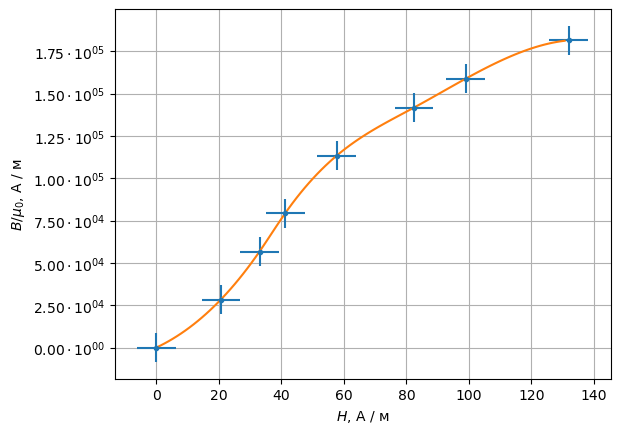

In [11]:
data = mipt.read_excel('data/345.ods', usecols=('A', 'B'), header=(0, 1), nrows=8)
foo(ferrit_list, 'Ferrit', data, setup.ferrit)


Fe-Si     
      x    y
0   0.0  0.0
1   0.3  0.4
2   0.6  0.8
3   0.8  1.0
4   1.0  1.2
5   1.6  1.6
6   2.4  1.8
7   3.0  2.0
8   4.0  2.2

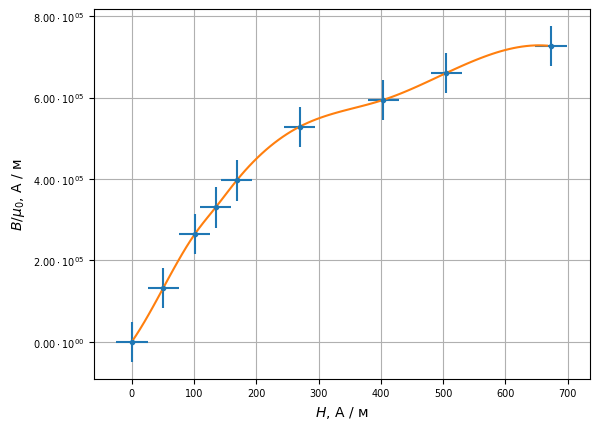

In [12]:
data = mipt.read_excel('data/345.ods', usecols=('D', 'E'), header=(0, 1), nrows=9)
foo(fesi_list, 'Fe-Si', data, setup.fesi)


Fe-Ni     
      x    y
0   0.0  0.0
1   0.1  0.1
2   0.2  0.2
3   0.4  1.2
4   0.6  1.6
5   1.0  1.8
6   1.4  1.8

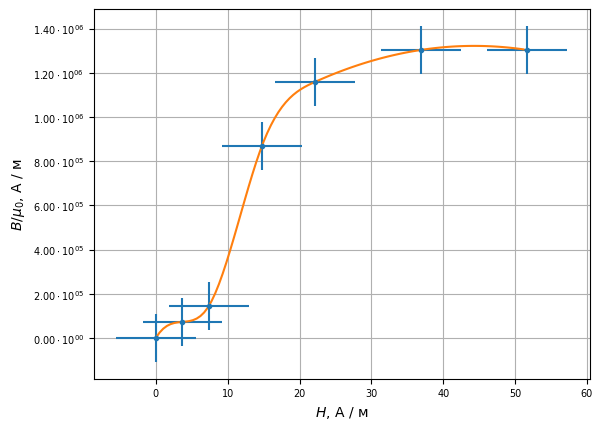

In [13]:
data = mipt.read_excel('data/345.ods', usecols=('G', 'H'), header=(0, 1), nrows=7)
foo(feni_list, 'Fe-Ni', data, setup.feni)


In [14]:
names_list.append("dB/dH_0")
names_list.append("dB/dH_max")

ferrit_list.append(setup.ferrit.ref_mu_0)
ferrit_list.append(setup.ferrit.ref_mu_max)

fesi_list.append(setup.fesi.ref_mu_0)
fesi_list.append(setup.fesi.ref_mu_max)

feni_list.append(setup.feni.ref_mu_0)
feni_list.append(setup.feni.ref_mu_max)


In [15]:
names_list.append("ref_dB/dH_0")
names_list.append("ref_dB/dH_max")


pd.DataFrame({"-" : names_list, "ferrit" : ferrit_list, "fesi" : fesi_list, "feni" : feni_list})

,-,ferrit,fesi,feni
0,dB/dH_0,1374.813970,2614.958570,19621.131422
1,dB/dH_max,2798.689443,2824.027486,113821.134842
2,ref_dB/dH_0,1000.000000,650.000000,10000.000000
3,ref_dB/dH_max,3000.000000,7000.000000,100000.000000


In [16]:
# names_list.append("dB/dH_0_ref")
# names_list.append("dB/dH_max_ref")

# ferrit_list.append(1000)

In [17]:

fmt = {
    'dB/dH_0' :  [r'$\frac{\mu_{диф}^0}{\mu_0} \cdot 10^{-3}$', '{:.1f}', -3],
    'dB/dH_max' :  [r'$\frac{\mu_{диф}^{max}}{\mu_0} \cdot 10^{-3}$', '{:.1f}', -3],
    'ref_dB/dH_0' :  [r'ref $\frac{\mu_{диф}^0}{\mu_0} \cdot 10^{-3}$', '{:.1f}', -3],
    'ref_dB/dH_max' :  [r'ref $\frac{\mu_{диф}^{max}}{\mu_0} \cdot 10^{-3}$', '{:.1f}', -3],
}

# names_list = [fmt.get(item, item) for item in fmt]

dat = pd.DataFrame({"-" : names_list, "ferrit" : ferrit_list, "fesi" : fesi_list, "feni" : feni_list})
dat = dat.set_index('-').transpose()
dat.insert(0, '--', ['Феррит', 'Fe-Si', 'Fe-Ni'])

tab = mipt.table(dat, fmt)
tab.rename().data
tab.to_latex('gen/tab_diff.tex')
dat

-,--,dB/dH_0,dB/dH_max,ref_dB/dH_0,ref_dB/dH_max
ferrit,Феррит,1374.813970,2798.689443,1000.0,3000.0
fesi,Fe-Si,2614.958570,2824.027486,650.0,7000.0
feni,Fe-Ni,19621.131422,113821.134842,10000.0,100000.0
